In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile as tiff
import torch
import cv2
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')
plt.style.use("Solarize_Light2")

In [2]:
class config:
    BASE_PATH = "../input/hubmap-organ-segmentation/"
    BASE_PATH_1 = "../input/hubmap-kidney-segmentation/"
    TRAIN_PATH = os.path.join(BASE_PATH, "train")

In [3]:
df = pd.read_csv(
    os.path.join(config.BASE_PATH, "train.csv")
)
df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


In [4]:
df['organ'].value_counts()

kidney            99
prostate          93
largeintestine    58
spleen            53
lung              48
Name: organ, dtype: int64

In [5]:
list_kidney_male = list(df[df['organ']=="kidney"][df['sex']=="Male"]['id'])
list_kidney_female = list(df[df['organ']=="kidney"][df['sex']=="Female"]['id'])
list_prostate_male = list(df[df['organ']=="prostate"][df['sex']=="Male"]['id'])
list_prostate_female = list(df[df['organ']=="prostate"][df['sex']=="Female"]['id'])
list_largeintestine_male = list(df[df['organ']=="largeintestine"][df['sex']=="Male"]['id'])
list_largeintestine_female = list(df[df['organ']=="largeintestine"][df['sex']=="Female"]['id'])
list_spleen_male = list(df[df['organ']=="spleen"][df['sex']=="Male"]['id'])
list_spleen_female = list(df[df['organ']=="spleen"][df['sex']=="Female"]['id'])
list_lung_male = list(df[df['organ']=="lung"][df['sex']=="Male"]['id'])
list_lung_female = list(df[df['organ']=="lung"][df['sex']=="Female"]['id'])

In [6]:
print("No of image of male kidney =", len(list_kidney_male))
print("No of image of female kidney =", len(list_kidney_female))
print("No of image of male prostate =", len(list_prostate_male))
print("No of image of female prostate =", len(list_prostate_female))
print("No of image of male largeintestine =", len(list_largeintestine_male))
print("No of image of female largeintestine =", len(list_largeintestine_female))
print("No of image of male spleen =", len(list_spleen_male))
print("No of image of female spleen =", len(list_spleen_female))
print("No of image of male lung =", len(list_lung_male))
print("No of image of female lung =", len(list_lung_female))

No of image of male kidney = 62
No of image of female kidney = 37
No of image of male prostate = 93
No of image of female prostate = 0
No of image of male largeintestine = 26
No of image of female largeintestine = 32
No of image of male spleen = 25
No of image of female spleen = 28
No of image of male lung = 23
No of image of female lung = 25


In [7]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [8]:
def plot_only_image(image):
    plt.figure(figsize=(16, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.grid(visible=False)
    plt.title("Test Image",fontsize=18)
    
    plt.show()

In [9]:
def plot_image_and_mask(image, mask, image_id, cmap):
    plt.figure(figsize=(16, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.grid(visible=False)
    plt.title(f"Image {image_id}", fontsize=18)
    
    plt.subplot(1, 3, 2)
    plt.grid(visible=False)
    plt.imshow(mask, cmap=cmap)
    plt.title(f"Mask", fontsize=18)    
    
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.grid(visible=False)
    plt.imshow(mask, cmap=cmap, alpha=0.5)
    plt.title(f"Image {image_id} + mask", fontsize=18)    
    
    plt.show()

image shape (3000, 3000, 3)
Mask shape (3000, 3000)


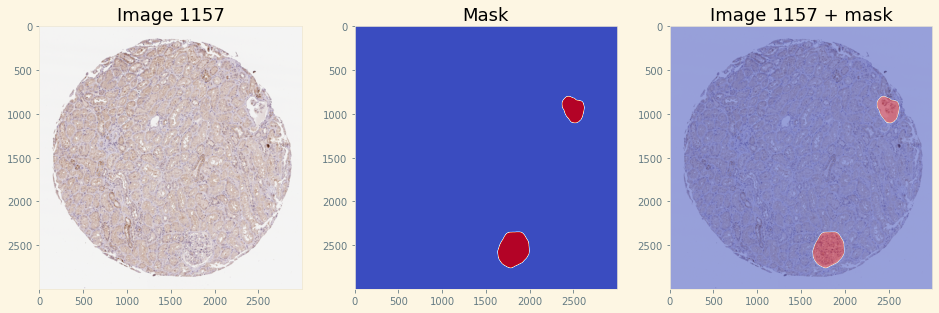

In [10]:
#Male Kidney
img_id_male_kid = list_kidney_male[0]
img_male_kid = tiff.imread(config.BASE_PATH + "train_images/" + str(img_id_male_kid) + ".tiff")
mask_male_kid = rle2mask(df[df["id"]==img_id_male_kid]["rle"].iloc[-1], (img_male_kid.shape[1], img_male_kid.shape[0]))
print("image shape", img_male_kid.shape)
print("Mask shape", mask_male_kid.shape)
plot_image_and_mask(img_male_kid, mask_male_kid, img_id_male_kid,'coolwarm')

image shape (3000, 3000, 3)
Mask shape (3000, 3000)


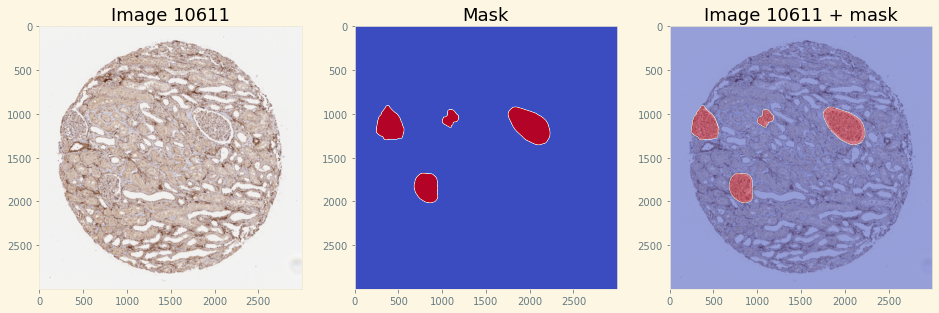

In [11]:
#Female Kidney
img_id_female_kid = list_kidney_female[0]
img_female_kid = tiff.imread(config.BASE_PATH + "train_images/" + str(img_id_female_kid) + ".tiff")
mask_female_kid = rle2mask(df[df["id"]==img_id_female_kid]["rle"].iloc[-1], (img_female_kid.shape[1], img_female_kid.shape[0]))
print("image shape", img_female_kid.shape)
print("Mask shape", mask_female_kid.shape)
plot_image_and_mask(img_female_kid, mask_female_kid, img_id_female_kid, 'coolwarm')

image shape (3000, 3000, 3)
Mask shape (3000, 3000)


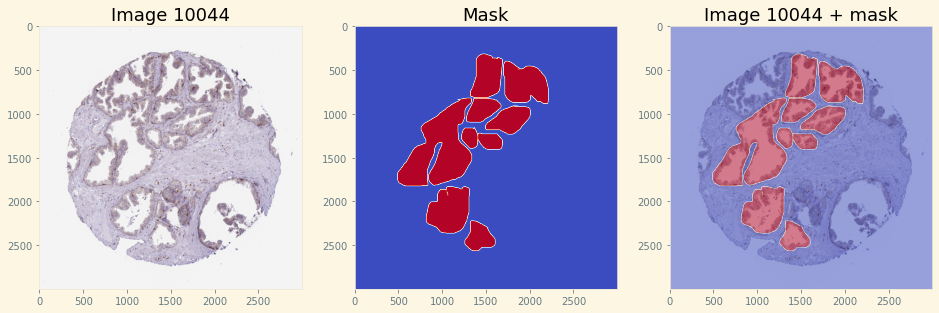

In [12]:
#Male Prostate
img_id_male_pro = list_prostate_male[0]
img_male_pro = tiff.imread(config.BASE_PATH + "train_images/" + str(img_id_male_pro) + ".tiff")
mask_male_pro = rle2mask(df[df["id"]==img_id_male_pro]["rle"].iloc[-1], (img_male_pro.shape[1], img_male_pro.shape[0]))
print("image shape", img_male_pro.shape)
print("Mask shape", mask_male_pro.shape)
plot_image_and_mask(img_male_pro, mask_male_pro, img_id_male_pro, 'coolwarm')

image shape (3000, 3000, 3)
Mask shape (3000, 3000)


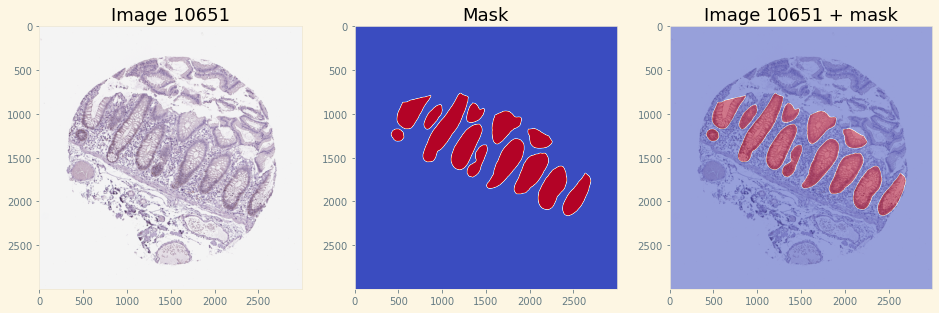

In [13]:
#Male largeintestine
img_id_male_li = list_largeintestine_male[0]
img_male_li = tiff.imread(config.BASE_PATH + "train_images/" + str(img_id_male_li) + ".tiff")
mask_male_li = rle2mask(df[df["id"]==img_id_male_li]["rle"].iloc[-1], (img_male_li.shape[1], img_male_li.shape[0]))
print("image shape", img_male_li.shape)
print("Mask shape", mask_male_li.shape)
plot_image_and_mask(img_male_li, mask_male_li, img_id_male_li, 'coolwarm')

image shape (3000, 3000, 3)
Mask shape (3000, 3000)


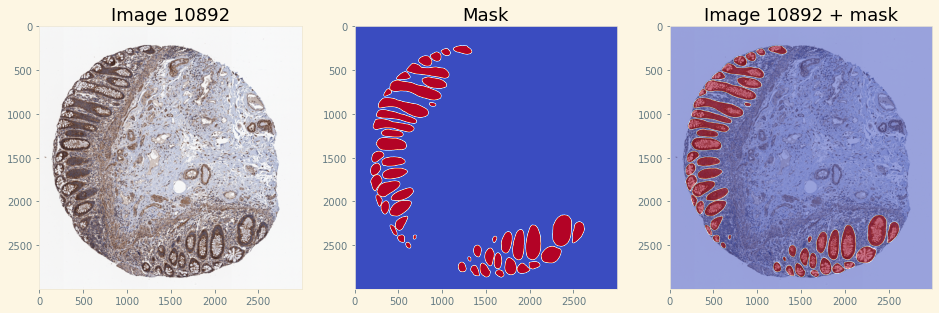

In [14]:
#Female largeintestine
img_id_female_li = list_largeintestine_female[0]
img_female_li = tiff.imread(config.BASE_PATH + "train_images/" + str(img_id_female_li) + ".tiff")
mask_female_li = rle2mask(df[df["id"]==img_id_female_li]["rle"].iloc[-1], (img_female_li.shape[1], img_female_li.shape[0]))
print("image shape", img_female_li.shape)
print("Mask shape", mask_female_li.shape)
plot_image_and_mask(img_female_li, mask_female_li, img_id_female_li, 'coolwarm')

image shape (3000, 3000, 3)
Mask shape (3000, 3000)


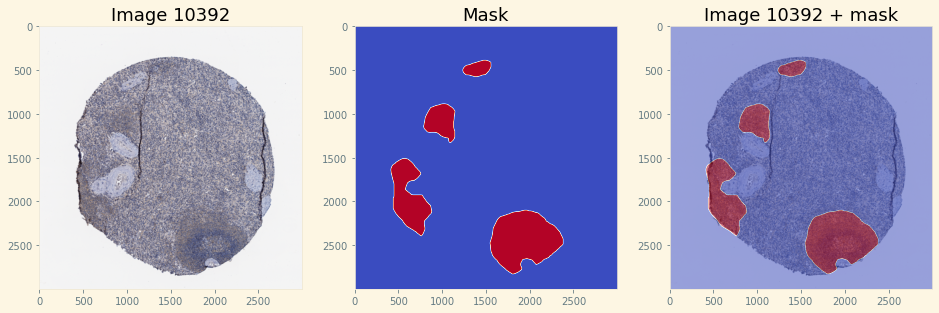

In [15]:
#Male spleen
img_id_male_spleen = list_spleen_male[0]
img_male_spleen = tiff.imread(config.BASE_PATH + "train_images/" + str(img_id_male_spleen) + ".tiff")
mask_male_spleen = rle2mask(df[df["id"]==img_id_male_spleen]["rle"].iloc[-1], (img_male_spleen.shape[1], img_male_spleen.shape[0]))
print("image shape", img_male_spleen.shape)
print("Mask shape", mask_male_spleen.shape)
plot_image_and_mask(img_male_spleen, mask_male_spleen, img_id_male_spleen, 'coolwarm')

image shape (3000, 3000, 3)
Mask shape (3000, 3000)


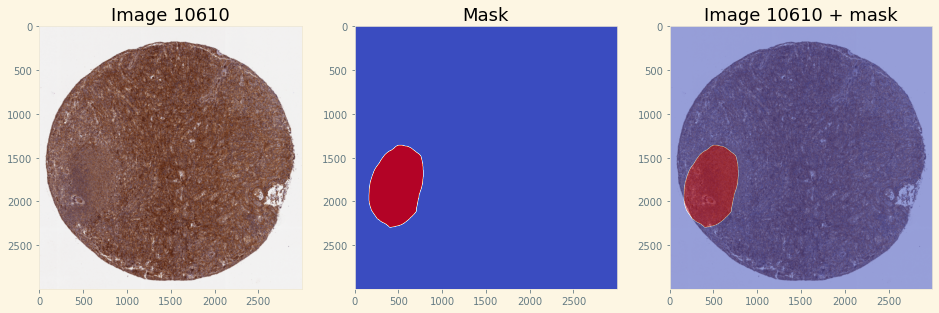

In [16]:
#female spleen
img_id_female_spleen = list_spleen_female[0]
img_female_spleen = tiff.imread(config.BASE_PATH + "train_images/" + str(img_id_female_spleen) + ".tiff")
mask_female_spleen = rle2mask(df[df["id"]==img_id_female_spleen]["rle"].iloc[-1], (img_female_spleen.shape[1], img_female_spleen.shape[0]))
print("image shape", img_female_spleen.shape)
print("Mask shape", mask_female_spleen.shape)
plot_image_and_mask(img_female_spleen, mask_female_spleen, img_id_female_spleen, 'coolwarm')

image shape (3000, 3000, 3)
Mask shape (3000, 3000)


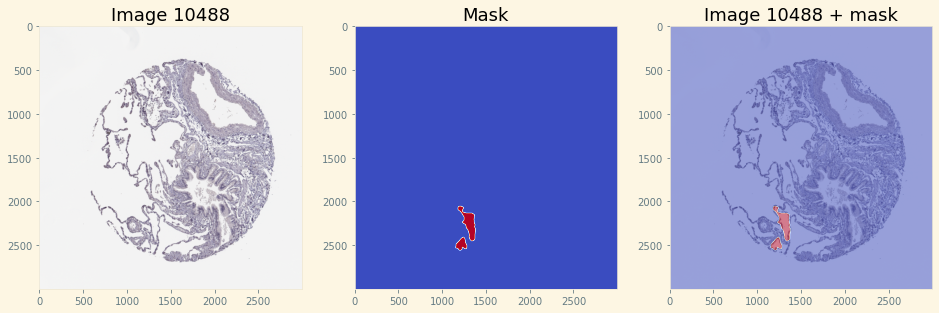

In [17]:
#Male lung
img_id_male_lung = list_lung_male[0]
img_male_lung = tiff.imread(config.BASE_PATH + "train_images/" + str(img_id_male_lung) + ".tiff")
mask_male_lung = rle2mask(df[df["id"]==img_id_male_lung]["rle"].iloc[-1], (img_male_lung.shape[1], img_male_lung.shape[0]))
print("image shape", img_male_lung.shape)
print("Mask shape", mask_male_lung.shape)
plot_image_and_mask(img_male_lung, mask_male_lung, img_id_male_lung, 'coolwarm')

image shape (3000, 3000, 3)
Mask shape (3000, 3000)


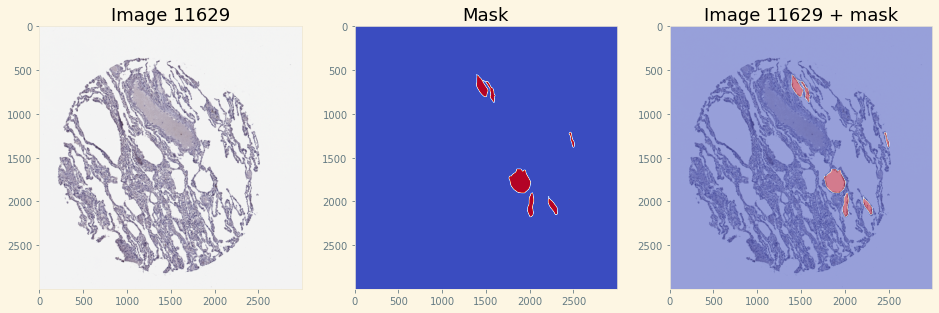

In [18]:
#female lung
img_id_female_lung = list_lung_female[0]
img_female_lung = tiff.imread(config.BASE_PATH + "train_images/" + str(img_id_female_lung) + ".tiff")
mask_female_lung = rle2mask(df[df["id"]==img_id_female_lung]["rle"].iloc[-1], (img_female_lung.shape[1], img_female_lung.shape[0]))
print("image shape", img_female_lung.shape)
print("Mask shape", mask_female_lung.shape)
plot_image_and_mask(img_female_lung, mask_female_lung, img_id_female_lung, 'coolwarm')

Prediction is tough for lung, there are no any image for female prostate

In [19]:
#Basic EDA
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                351 non-null    int64  
 1   organ             351 non-null    object 
 2   data_source       351 non-null    object 
 3   img_height        351 non-null    int64  
 4   img_width         351 non-null    int64  
 5   pixel_size        351 non-null    float64
 6   tissue_thickness  351 non-null    int64  
 7   rle               351 non-null    object 
 8   age               351 non-null    float64
 9   sex               351 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 27.5+ KB


In [20]:
df['data_source'].value_counts()

HPA    351
Name: data_source, dtype: int64

<AxesSubplot:>

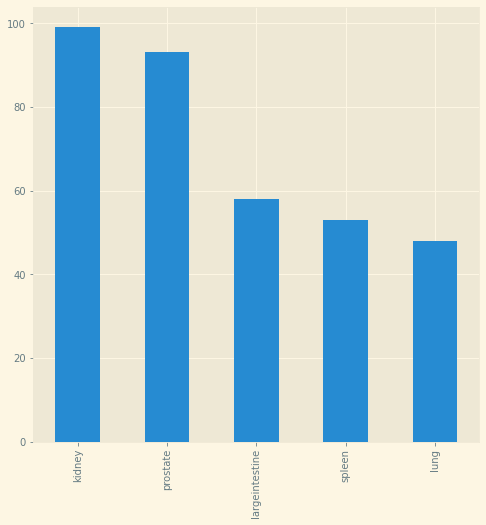

In [21]:
plt.figure(figsize=(8, 8))
df['organ'].value_counts().plot(kind='bar')

<AxesSubplot:>

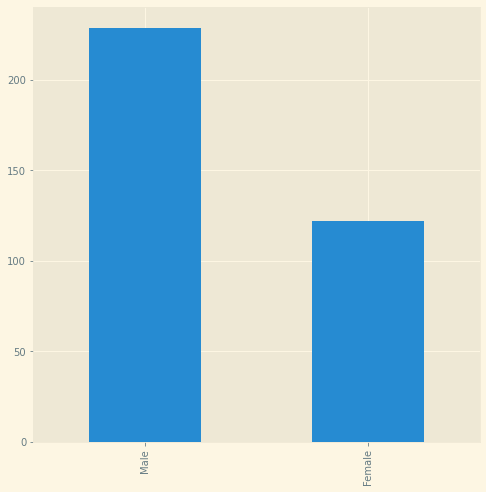

In [22]:
plt.figure(figsize=(8, 8))
df['sex'].value_counts().plot(kind='bar')

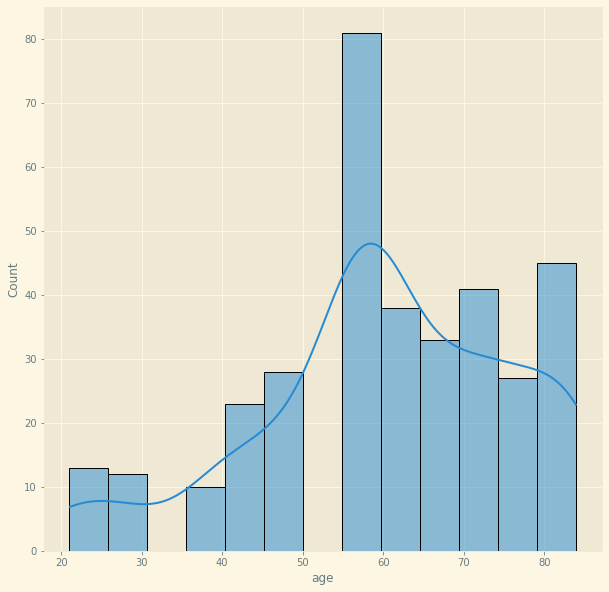

In [23]:
plt.figure(figsize=(10, 10))
sns.histplot(x="age", kde=True, data=df)
plt.show()

<AxesSubplot:xlabel='organ', ylabel='count'>

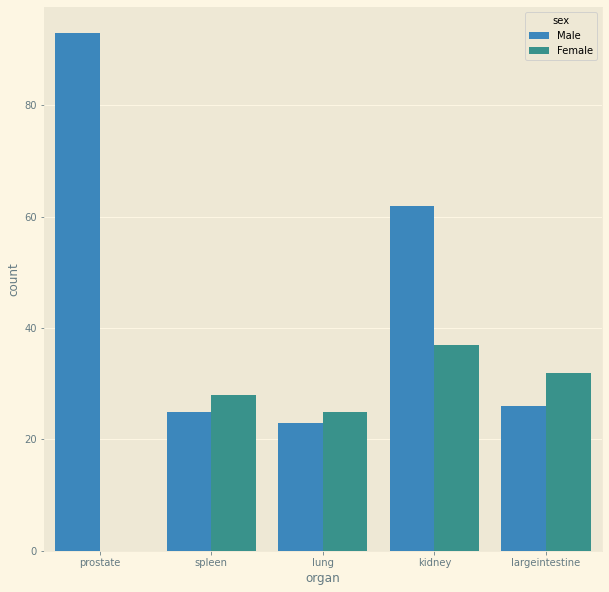

In [24]:
plt.figure(figsize=(10, 10))
sns.countplot(x="organ", hue="sex", data=df)

<AxesSubplot:>

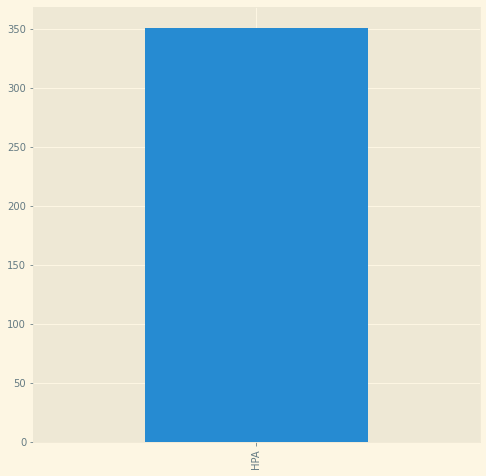

In [25]:
plt.figure(figsize=(8, 8))
df['data_source'].value_counts().plot(kind='bar')

In [26]:
#EDA of teset dataset

In [27]:
df_test = pd.read_csv(
    os.path.join(config.BASE_PATH, "test.csv")
)
df_test.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness
0,10078,spleen,Hubmap,2023,2023,0.4945,4


<AxesSubplot:>

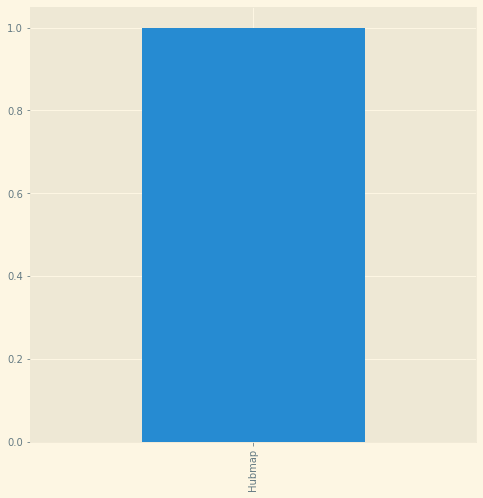

In [28]:
plt.figure(figsize=(8, 8))
df_test['data_source'].value_counts().plot(kind='bar')

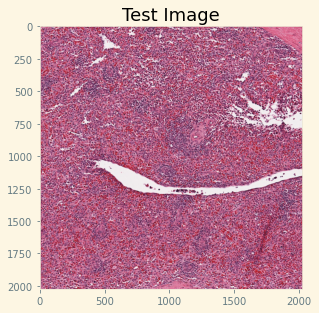

In [29]:
img_test = tiff.imread(config.BASE_PATH + "test_images/" + "10078.tiff")
plot_only_image(img_test)

In [30]:
#Previous year hubmap data

In [31]:
df_test = pd.read_csv(
    os.path.join(config.BASE_PATH, "test.csv")
)
df_test.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness
0,10078,spleen,Hubmap,2023,2023,0.4945,4


In [32]:
df_prev_yr = pd.read_csv(
    os.path.join(config.BASE_PATH_1, "train.csv")
)
df_prev_yr.head()

,id,encoding
0,2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
1,8242609fa,96909968 56 96941265 60 96972563 64 97003861 6...
2,aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
3,cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
4,b9a3865fc,61271840 4 61303134 13 61334428 22 61365722 30...


In [33]:
# #Male Kidney
# img_id = df_prev_yr['id'][0]
# img = tiff.imread(config.BASE_PATH_1 + "train/" + str(img_id) + ".tiff")
# mask = rle2mask(df_prev_yr[df_prev_yr["id"]==img_id]["encoding"].iloc[-1], (img.shape[1], img.shape[0]))
# print("image shape", img.shape)
# print("Mask shape", mask.shape)
# plot_image_and_mask(img, mask, img_id,'coolwarm')